## Solution to the second project

#### All the imports here

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace, vstack, zeros, arange, power, abs
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import norm
import random



#### Making matplotlib more tolerable

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline
plt.xkcd();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Plotting functions below

In [3]:
#plotting functions here

### Task 2.1 (yobibyte)

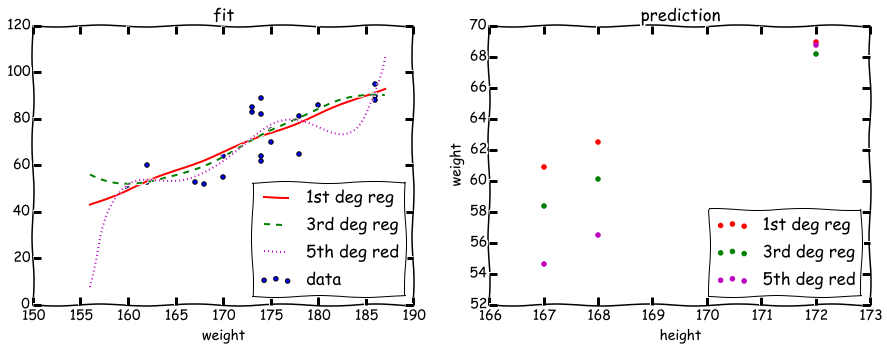

In [4]:
dt = np.dtype([('w', np.float), ('h', np.float), ('g', 'S1')])
data = np.loadtxt('resources/whData.dat', dtype=dt, comments='#', delimiter=None)

ws = data['w']
hs = data['h']
gs = np.array([el.decode('utf-8') for el in data['g']])

hs_t = hs[np.where(ws < 0)]
gs_t = gs[np.where(ws < 0)]
ws_t = ws[np.where(ws < 0)]

hs = np.delete(hs, np.where(ws < 0), None)
gs = np.delete(gs, np.where(ws < 0), None)
ws = np.delete(ws, np.where(ws < 0), None)

p = np.poly1d(polyfit(hs,ws,1))
p3 = np.poly1d(polyfit(hs,ws,3))
p5 = np.poly1d(polyfit(hs,ws,5))
xp = np.linspace(156, 187, 100)

colors = ['r'if el=='f' else 'b' for el in gs]

fig,axes = subplots(ncols=2, figsize=(15,5))
ax = axes[0]
ax2 = axes[1]

ax.set_title('fit')
ax.set_xlabel('height')
ax.set_xlabel('weight')
ax.scatter(hs, ws, label='data')
ax.plot(xp, p(xp), '-', label='1st deg reg', color='r')
ax.plot(xp, p3(xp), '--', label='3rd deg reg',color='g')
ax.plot(xp, p5(xp), ':', label='5th deg red',color='m')
legend = ax.legend(loc='lower right')

ax2.set_ylabel('weight')
ax2.set_xlabel('height')
ax2.set_title('prediction')
ax2.scatter(hs_t, p(hs_t), label='1st deg reg', color='r')
ax2.scatter(hs_t, p3(hs_t), label='3rd deg reg',color='g')
ax2.scatter(hs_t, p5(hs_t), label='5th deg red',color='m')
legend = ax2.legend(loc='lower right')

### Task 2.2

In [5]:
#Code here

### Task 2.3

In [6]:
#Code here

### Task 2.4 (yobibyte)

In [7]:
#Code here

### Task 2.5

In [8]:
#Code here